#Соревнование
https://www.kaggle.com/c/platesv2/overview

#Необходимые ресурсы

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.keras.optimizers import Adam

In [4]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
import random
import os
import zipfile
import io, shutil

#Загружаем токен аутентификации

In [5]:
file = files.upload()

Saving kaggle.json to kaggle.json


#Копируем токен в каталог .kaggle

In [6]:
!mkdir ~/.kaggle


In [7]:
!mv kaggle.json ~/.kaggle

In [8]:
!chmod 600 /root/.kaggle/kaggle.json

#Загружаем данные с сайта Kaggle

In [9]:
!kaggle competitions download -c platesv2

 98% 46.0M/47.0M [00:02<00:00, 33.2MB/s]
100% 47.0M/47.0M [00:02<00:00, 21.4MB/s]


In [10]:
!ls

platesv2.zip  sample_data


In [12]:
!unzip platesv2.zip

Archive:  platesv2.zip
  inflating: plates.zip              
  inflating: sample_submission.csv   


Data fields

- id - id of an image from the test folder.
If image name is 0123.jpg its id will be 0123

- label - predicted label. One of: dirty, cleaned

In [13]:
!head sample_submission.csv

id,label
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty
0008,dirty


In [14]:
!unzip plates.zip

Archive:  plates.zip
   creating: plates/
  inflating: plates/.DS_Store        
   creating: __MACOSX/
   creating: __MACOSX/plates/
  inflating: __MACOSX/plates/._.DS_Store  
   creating: plates/test/
  inflating: plates/test/0071.jpg    
  inflating: plates/test/0717.jpg    
  inflating: plates/test/0703.jpg    
  inflating: plates/test/0065.jpg    
  inflating: plates/test/0059.jpg    
  inflating: plates/test/0515.jpg    
  inflating: plates/test/0273.jpg    
  inflating: plates/test/0267.jpg    
  inflating: plates/test/0501.jpg    
  inflating: plates/test/0529.jpg    
  inflating: plates/test/0298.jpg    
  inflating: plates/test/0461.jpg    
  inflating: plates/test/0307.jpg    
  inflating: plates/test/0313.jpg    
  inflating: plates/test/0475.jpg    
  inflating: plates/test/0449.jpg    
  inflating: plates/test/0105.jpg    
  inflating: plates/test/0663.jpg    
  inflating: plates/test/0677.jpg    
  inflating: plates/test/0111.jpg    
  inflating: plates/test/0139.jpg    


In [15]:
!ls

__MACOSX  plates  platesv2.zip	plates.zip  sample_data  sample_submission.csv


In [16]:
# подсчитаем количество файлов в датасете cleaned
!find /content/plates/train/cleaned -type f| wc -l

21


In [17]:
# подсчитаем количество файлов в датасете dirty
!find /content/plates/train/dirty -type f| wc -l

21


In [18]:
# подсчитаем количество файлов в датасете test
!find /content/plates/test -type f| wc -l

745


#Просмотр изображений из датасета

In [19]:
from PIL import Image

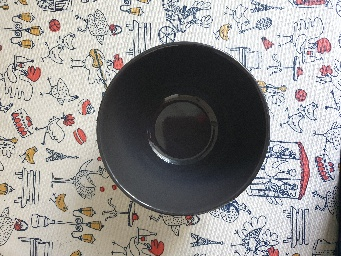

In [20]:
img=Image.open('/content/plates/train/cleaned/0000.jpg')
display(img)

In [21]:
img.size

(341, 256)

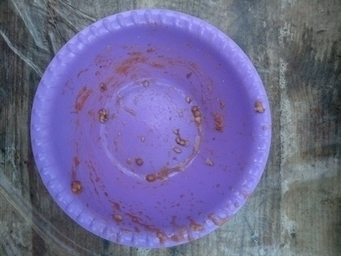

In [22]:
img=Image.open('/content/plates/test/0000.jpg')
display(img)

In [23]:
img.size

(341, 256)

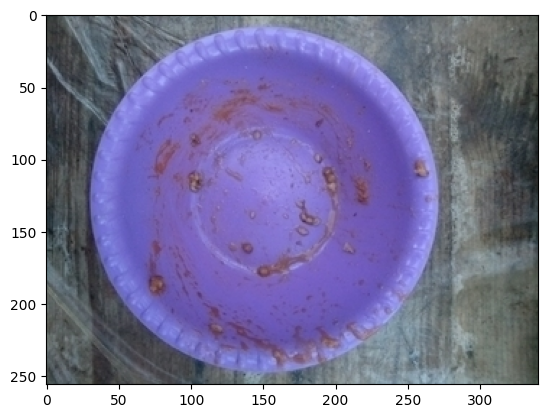

In [24]:
plt.imshow(img)
plt.show()

#Генерация датасетов

In [25]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [26]:
image_size = (250, 250)
batch_size = 10

train_ds = image_dataset_from_directory(
    "plates/train",
    validation_split=0.15,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = image_dataset_from_directory(
    "plates/train",
    validation_split=0.15,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 40 files belonging to 2 classes.
Using 34 files for training.
Found 40 files belonging to 2 classes.
Using 6 files for validation.


In [27]:
train_ds.class_names

['cleaned', 'dirty']

#Visualize the data

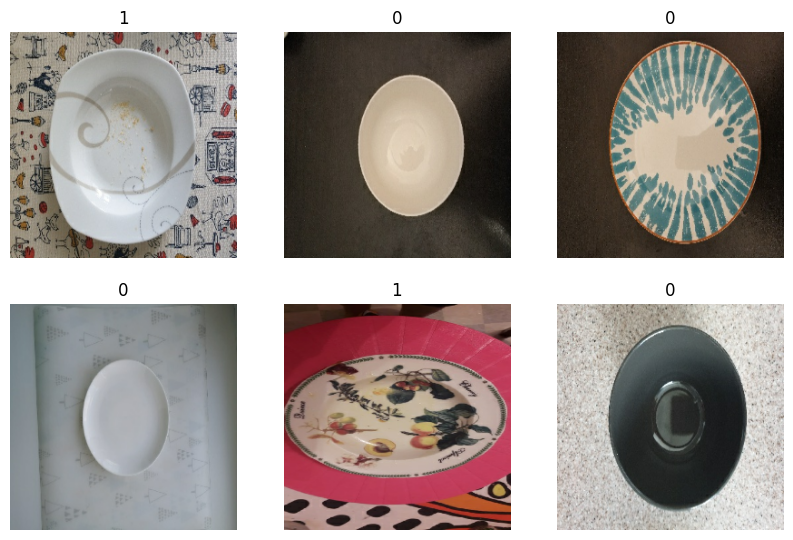

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#Using image data augmentation

In [29]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.45),
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomContrast(0.1),


    ]
)

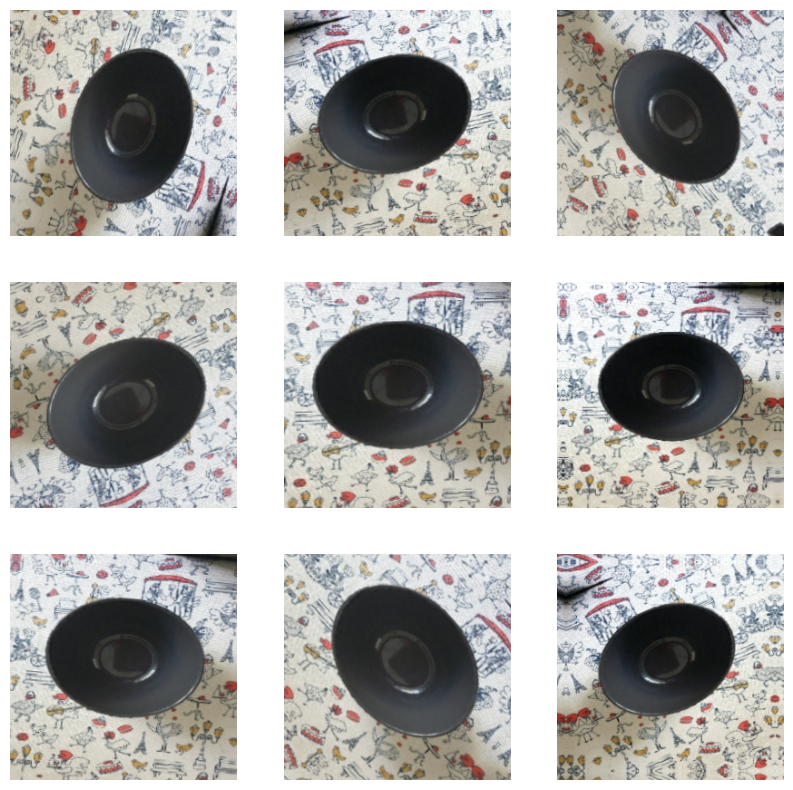

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#Build a model

In [31]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

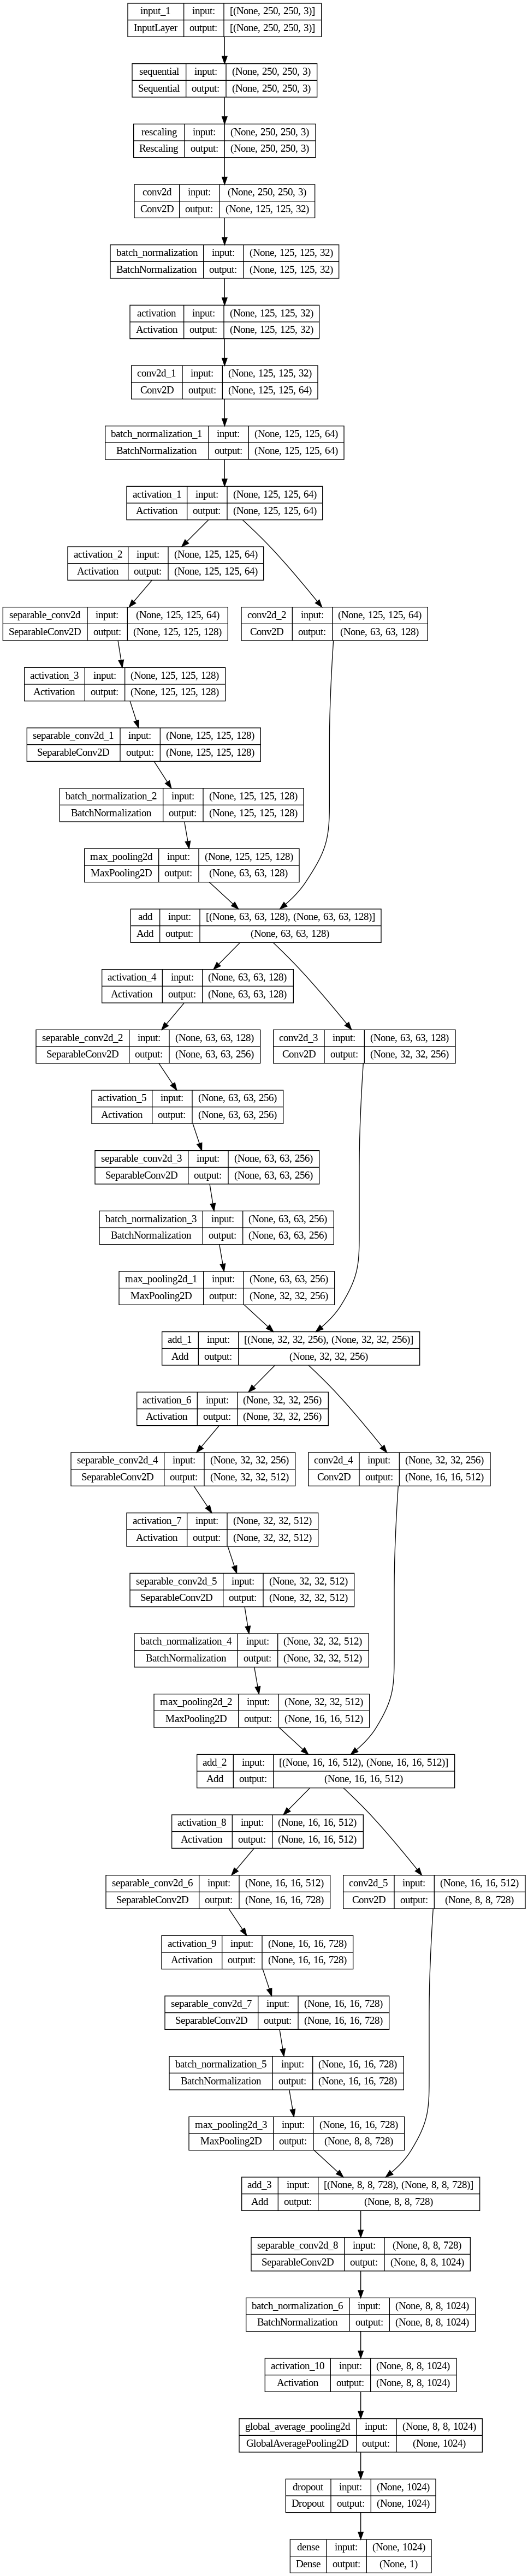

In [32]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        #x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

#Train the model

In [33]:
epochs = 200

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(train_ds, epochs=epochs, callbacks=[callbacks], validation_data=val_ds)

Epoch 1/200
4/4 [==============================] - 23s 738ms/step - loss: 0.8985 - accuracy: 0.3235 - val_loss: 0.7012 - val_accuracy: 0.1667
Epoch 2/200
4/4 [==============================] - 0s 92ms/step - loss: 0.6757 - accuracy: 0.5882 - val_loss: 0.7003 - val_accuracy: 0.1667
Epoch 3/200
4/4 [==============================] - 0s 101ms/step - loss: 0.7516 - accuracy: 0.5882 - val_loss: 0.6993 - val_accuracy: 0.1667
Epoch 4/200
4/4 [==============================] - 0s 93ms/step - loss: 0.6965 - accuracy: 0.5588 - val_loss: 0.7008 - val_accuracy: 0.1667
Epoch 5/200
4/4 [==============================] - 0s 100ms/step - loss: 0.6799 - accuracy: 0.6471 - val_loss: 0.7099 - val_accuracy: 0.1667
Epoch 6/200
4/4 [==============================] - 0s 101ms/step - loss: 0.7348 - accuracy: 0.5000 - val_loss: 0.7088 - val_accuracy: 0.1667
Epoch 7/200
4/4 [==============================] - 0s 83ms/step - loss: 0.6102 - accuracy: 0.6176 - val_loss: 0.7022 - val_accuracy: 0.1667
Epoch 8/200
4/4

#Визуализация обучения

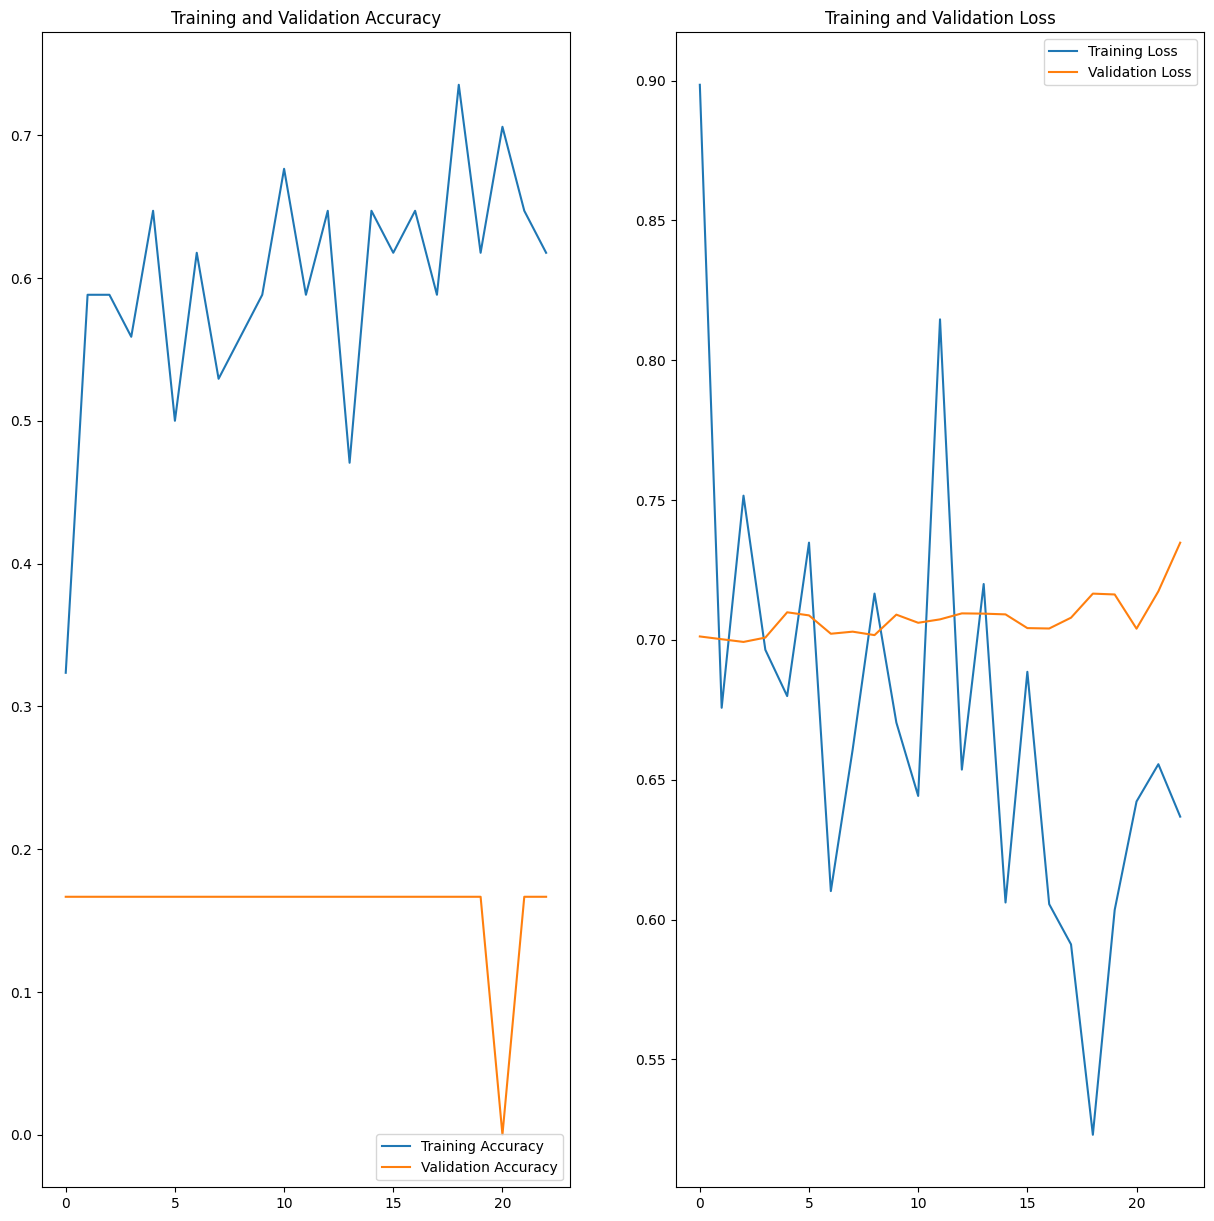

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

#epochs_range = range(22)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Test Data

In [35]:
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        'plates',
        classes=['test'],
        target_size = (200, 200),
        batch_size = 10,
        shuffle = False,
        class_mode = None)

Found 744 images belonging to 1 classes.


In [36]:
#test_generator.reset()
predict = model.predict_generator(test_generator, steps = len(test_generator.filenames))
len(predict)

<ipython-input-36-538265efe8a2>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps = len(test_generator.filenames))


744

In [37]:
type(predict)

numpy.ndarray

In [38]:
predict[1:5]

array([[0.45327744],
       [0.4698199 ],
       [0.46434212],
       [0.46246612]], dtype=float32)

#Подготовка решения на Kaggle

In [39]:
submission_df = pd.read_csv('/content/sample_submission.csv')
submission_df.head()

,id,label
0,0,dirty
1,1,dirty
2,2,dirty
3,3,dirty
4,4,dirty


In [40]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      744 non-null    int64 
 1   label   744 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


In [41]:
submission_df['label'] = predict

In [42]:
submission_df.head(10)

,id,label
0,0,0.462196
1,1,0.453277
2,2,0.469820
3,3,0.464342
4,4,0.462466
5,5,0.472576
6,6,0.475045
7,7,0.455863
8,8,0.459130
9,9,0.470387


In [43]:
submission_df['label'] = submission_df['label'].apply(lambda x: 'dirty' if x > 0.5 else 'cleaned')

In [ ]:
#submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')

In [44]:
submission_df.head(10)

,id,label
0,0,cleaned
1,1,cleaned
2,2,cleaned
3,3,cleaned
4,4,cleaned
5,5,cleaned
6,6,cleaned
7,7,cleaned
8,8,cleaned
9,9,cleaned


#Посмотрим на распределение изображений

<Axes: >

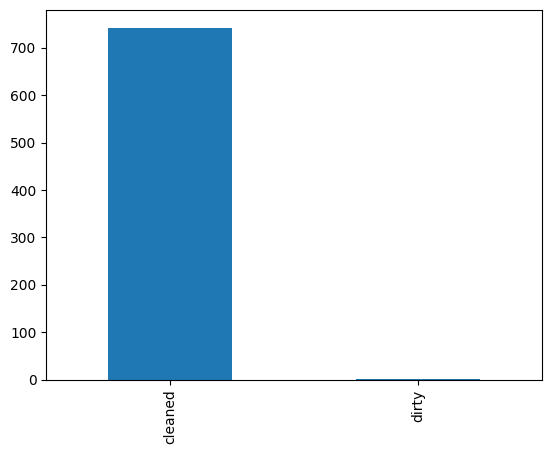

In [45]:
submission_df['label'].value_counts().plot.bar()

In [46]:
submission_df.label.value_counts()

cleaned    743
dirty        1
Name: label, dtype: int64

In [47]:
submission_df.set_index('id', inplace=True)

In [48]:
submission_df

,label
id,
0,cleaned
1,cleaned
2,cleaned
3,cleaned
4,cleaned
...,...
739,cleaned
740,cleaned
741,cleaned


In [49]:
submission_df.to_csv('submission.csv')

# Отправляем решение на соревнование

In [50]:
!kaggle competitions submit -c platesv2 -m "Submition from Colab" -f submission.csv

100% 8.62k/8.62k [00:00<00:00, 11.5kB/s]
Successfully submitted to Cleaned vs Dirty V2

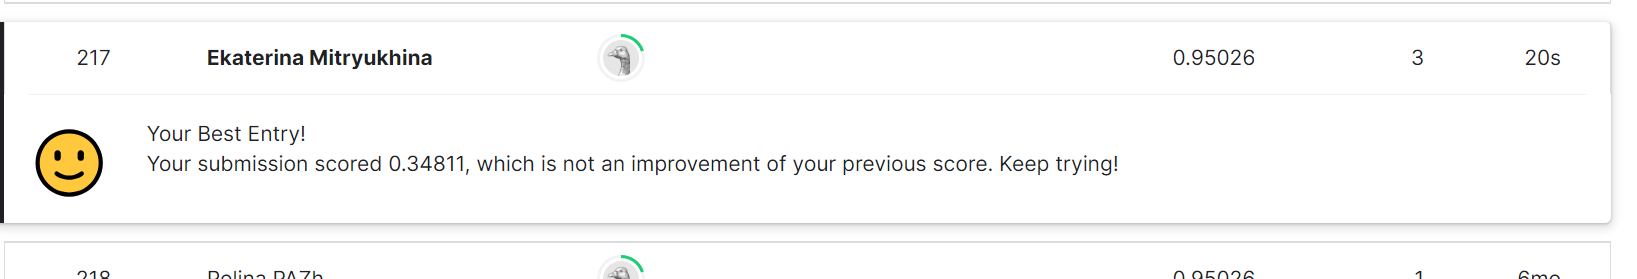